<a href="https://colab.research.google.com/github/Rahul20037237/Build_your_own_NN/blob/main/ViT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**patch_embedding**

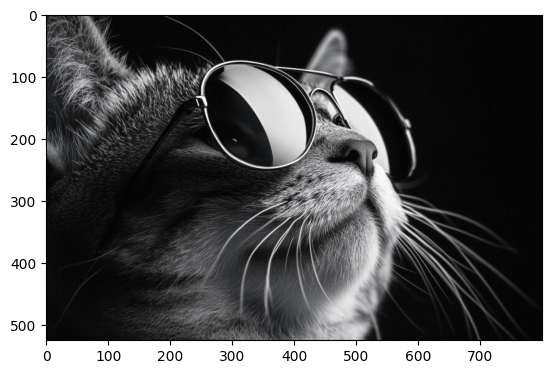

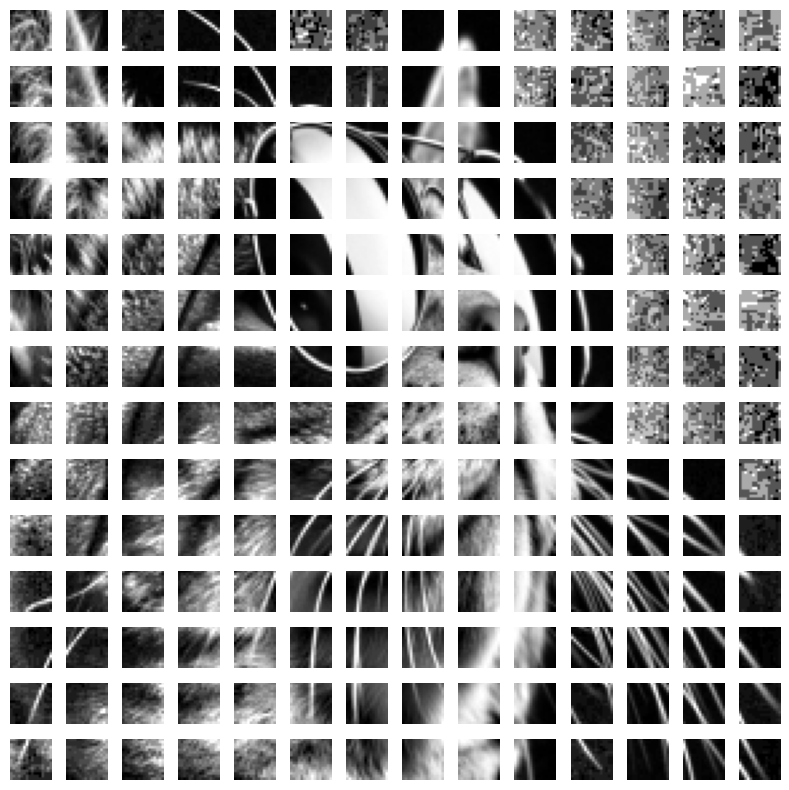

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchvision.transforms import Compose, Resize, ToTensor
image = Image.open('/content/gratisography-cool-cat-800x525 (1).jpg')
plt.imshow(image)
transform = Compose([Resize((224, 224)), ToTensor()])
image = transform(image).unsqueeze(0)
image.shape

patch_size = 16
grid_size = 224 // patch_size
patches = rearrange(image, 'b c (h p1) (w p2) -> b (h w) c p1 p2', p1=patch_size, p2=16)

plt.figure(figsize=(8, 8))
for i in range(grid_size):
    for j in range(grid_size):
        patch = patches[0, i * grid_size + j, 0]
        plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
        plt.imshow(patch.detach().numpy(), cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn
from tensorflow import einsum
from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange

In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [3]:
class PreNorm(Layer):
    def __init__(self, fn):
        super().__init__()

        self.norm = nn.LayerNormalization()
        self.fn = fn
    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)

In [4]:
class MLP(Layer):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()

        def GELU():
            def gelu(x, approximate=False):
                if approximate:
                    coeff = tf.cast(0.044715, x.dtype)
                    return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
                else:
                    return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

            return nn.Activation(gelu)

        self.net = Sequential([
            nn.Dense(units=hidden_dim),
            GELU(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

In [5]:
class Attention(Layer):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax()
        self.to_qkv = nn.Dense(units=inner_dim * 3, use_bias=False)

        if project_out:
            self.to_out = [
                nn.Dense(units=dim),
                nn.Dropout(rate=dropout)
            ]
        else:
            self.to_out = []
        self.to_out = Sequential(self.to_out)
    def call(self, x, training=True):
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # dots = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2])) * self.scale
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)

        # x = tf.matmul(attn, v)
        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.to_out(x, training=training)

        return x

In [6]:
class Transformer(Layer):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super(Transformer, self).__init__()

        self.layers = []

        for _ in range(depth):
            self.layers.append([
                PreNorm(Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(MLP(dim, mlp_dim, dropout=dropout))
            ])

    def call(self, x, training=True):
        for attn, mlp in self.layers:
            x = attn(x, training=training) + x
            x = mlp(x, training=training) + x

        return x


In [7]:

class ViT(Model):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim,
                 pool='cls', dim_head=64, dropout=0.0, emb_dropout=0.0):
        super().__init__()

        image_height, image_width = pair(image_size)
        print(f"Image shape: {image_size}, Patch size: {patch_size}")
        patch_height, patch_width = pair(patch_size)
        print(f"Patch height: {patch_height}, Patch width: {patch_width}")
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0,'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_embedding = Sequential([
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width), # Use tensorflow Rearrange
            nn.Dense(units=dim)
        ], name='patch_embedding')

        self.pos_embedding = tf.Variable(initial_value=tf.random.normal([1, num_patches + 1, dim]))
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, dim]))
        self.dropout = nn.Dropout(rate=emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.mlp_head = Sequential([
            nn.LayerNormalization(),
            nn.Dense(units=num_classes)
        ], name='mlp_head')

    def call(self, img, training=True, **kwargs):
        # print(f"Input image shape: {img.shape}")
        x = self.patch_embedding(img)
        b, n, d = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x, training=training)

        x = self.transformer(x, training=training)

        if self.pool == 'mean':
            x = tf.reduce_mean(x, axis=1)
        else:
            x = x[:, 0]

        x = self.mlp_head(x)

        return x

In [23]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
print(y_train[0])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

[6]
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [107]:
def preprocess_data(image, label):
    # image = tf.image.resize(image, (32, 32))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    label = tf.one_hot(tf.cast(label, tf.int32), depth=10)
    return image, tf.squeeze(label)

def prepare_dataset(dataset, batch_size):
    return (dataset
            .map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(1000)
            .batch(batch_size)
            .map(lambda x, y: (tf.ensure_shape(x, [batch_size, 32, 32, 3]),
                               tf.ensure_shape(y, [batch_size,10])))
            .prefetch(tf.data.AUTOTUNE))

In [108]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = prepare_dataset(train_dataset, batch_size=10)
test_dataset = prepare_dataset(test_dataset, batch_size=10)

In [98]:
print(train_dataset.element_spec)

(TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.int64, name=None))


In [109]:
model = ViT(
    image_size=(32, 32),
    patch_size=4,        # Try smaller patch size
    num_classes=10,
    dim=256,
    depth=12,
    heads=16,
    mlp_dim=512,
    dropout=0.2,
    emb_dropout=0.2
)

Image shape: (32, 32), Patch size: 4
Patch height: 4, Patch width: 4


In [67]:
class WarmupCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, warmup_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_lr, decay_steps)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.initial_lr * (step / tf.cast(self.warmup_steps, tf.float32))
        cosine_lr = self.cosine_decay(step - self.warmup_steps)
        return tf.where(step < self.warmup_steps, warmup_lr, cosine_lr)
def get_optimizer():
    lr_schedule = WarmupCosineDecayScheduler(initial_lr=1e-4, decay_steps=10000, warmup_steps=1000)
    return tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

In [110]:
optimizers=get_optimizer()
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4,weight_decay=1e-4),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(train_dataset, validation_data=test_dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 332s 43ms/step - accuracy: 0.1763 - loss: 2.2263 - val_accuracy: 0.3015 - val_loss: 1.9181
Epoch 2/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 224s 44ms/step - accuracy: 0.3037 - loss: 1.9075 - val_accuracy: 0.3851 - val_loss: 1.6947
Epoch 3/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 208s 42ms/step - accuracy: 0.3571 - loss: 1.7601 - val_accuracy: 0.4161 - val_loss: 1.6010
Epoch 4/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 268s 43ms/step - accuracy: 0.3904 - loss: 1.6709 - val_accuracy: 0.4343 - val_loss: 1.5462
Epoch 5/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 252s 41ms/step - accuracy: 0.4225 - loss: 1.5942 - val_accuracy: 0.4644 - val_loss: 1.4795
Epoch 6/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 261s 41ms/step - accuracy: 0.4401 - loss: 1.5420 - val_accuracy: 0.4757 - val_loss: 1.4466
Epoch 7/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 264s 41ms/step - accuracy: 0.4571 - loss: 1.4961 - val_accuracy: 0.4928 - val_loss: 1.4136
Epoch 8/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 266s 42ms/step - accuracy: 

In [ ]:
from tensorflow.keras.applications import